In [41]:
using LinearAlgebra;
using StaticArrays;
using Makie
using Makie:Point2f0
using CairoMakie
using Printf
using Symbolics


### Construction of the Hamiltonian ## 

In [58]:
# Here, we define the three vectors connecting nearest neighbor carbon atoms 
global const C_6::Matrix{Float64} = [cos(2.0*pi/3.0) -sin(2.0*pi/3.0); sin(2.0*pi/3.0) cos(2.0*pi/3.0)]
global const A1::Vector{Float64} = [1.0, 0.0]
global const A2::Vector{Float64} = C_6 * A1
global const A3::Vector{Float64} = C_6 * A2; 

# To define the Haldane term, we need B1, B2, and B3. They obey B1 + B2 + B3 = 0 
global const B1::Vector{Float64} = A2 - A1
global const B2::Vector{Float64} = A3 - A2 
global const B3::Vector{Float64} = A1 - A3; 


# Pauli Sigma Matrices 
global const sigma_x  = @SArray ComplexF64[0.0 1.0; 1.0 0.0]
global const sigma_y  = @SArray ComplexF64[0.0 -im; im 0.0]
global const sigma_z  = @SArray ComplexF64[1.0 0.0; 0.0 -1.0];


In [67]:
function plot_CC_bonds(A1::Vector{Float64}, A2::Vector{Float64}, A3::Vector{Float64})
    origin = Point2f0(0, 0)
    A1 = Point2f0(A1...)
    A2 = Point2f0(A2...)
    A3 = Point2f0(A3...)
    f = Figure()
    ax = Axis(f[1, 1], title = "Carbon-Carbon Bonds", aspect = 1)
    # Plot the B Arrows 
    B1_origin = A1
    B2_origin = A2 
    B3_origin = A3 
    arrows!(ax, [B1_origin, B2_origin, B3_origin], [B1, B2, B3], arrowsize = 0.2, linewidth = 4.0, color = :blue)
    # Plot the A Arrows
    arrows!(ax, [origin, origin, origin], [A1, A2, A3], arrowsize = 16.2, linewidth = 6.0, color = :red)

    ax.xlabel = L"k_x"
    ax.ylabel = L"k_y"
    f
end



plot_CC_bonds (generic function with 1 method)

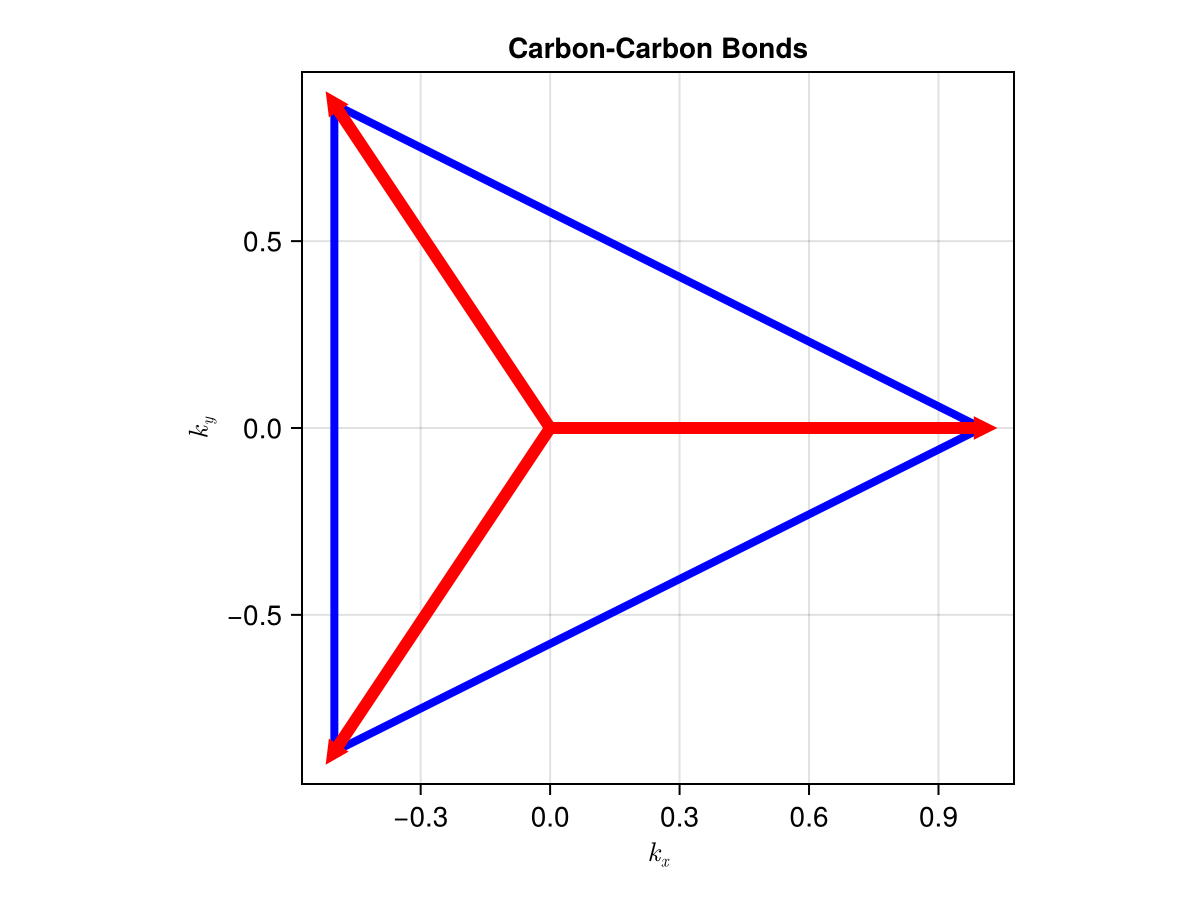

In [68]:
plot_CC_bonds(A1, A2, A3)

In [48]:
# Compute k1, k2, k3 using CAS provided in Symbolics 
@variables k1 k2 k3 kx ky
@variables k
k = [kx ky]
k1 = dot(k, A1)
k2 = dot(k, A2)
k3 = dot(k, A3);

println("k1 = ", k1)
println("k2 = ", k2)
println("k3 = ", k3)

k1 = kx
k2 = -0.4999999999999998kx + 0.8660254037844387ky
k3 = -0.5000000000000003kx - 0.8660254037844384ky


In [70]:
# Compute q1, q2, q3 using CAS provided in Symbolics 
@variables q1 q2 q3
@variables q
q = [kx ky]
q1 = dot(q, B1)
q2 = dot(q, B2)
q3 = dot(q, B3);

println("q1 = ", q1)
println("q2 = ", q2)
println("q3 = ", q3)

q1 = -1.4999999999999998kx + 0.8660254037844387ky
q2 = -5.551115123125783e-16kx - 1.7320508075688772ky
q3 = 1.5000000000000004kx + 0.8660254037844384ky


In [76]:
# Finally construct H 
@inline function H_Haldane(k::Vector{Float64}, M::Float64, t2::Float64)
    kx = k[1]; ky = k[2]
    gx = cos(kx) + cos(-0.5 * kx + 0.5 * sqrt(3.0) * ky) + cos(-0.5 * kx - 0.5 * sqrt(3.0) * ky)
    gy = -sin(kx) - sin(-0.5 * kx + 0.5 * sqrt(3.0) * ky) - sin(-0.5 * kx - 0.5 * sqrt(3.0) * ky)
    gz = M + 2.0 * t2 * (sin(-0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky) + sin(-sqrt(3.0) * ky) + sin(0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky))
    gx * sigma_x + gy * sigma_y + gz * sigma_z 
end 

# evals 
@inline function evals(k::Vector{Float64}, M::Float64, t2::Float64)
    kx = k[1]; ky = k[2]
    gx = cos(kx) + cos(-0.5 * kx + 0.5 * sqrt(3.0) * ky) + cos(-0.5 * kx - 0.5 * sqrt(3.0) * ky)
    gy = -sin(kx) - sin(-0.5 * kx + 0.5 * sqrt(3.0) * ky) - sin(-0.5 * kx - 0.5 * sqrt(3.0) * ky)
    gz = M + 2.0 * t2 * (sin(-0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky) + sin(-sqrt(3.0) * ky) + sin(0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky))
    eigvals(gx * sigma_x + gy * sigma_y + gz * sigma_z) 
end 

# eigensystem 
@inline function evals(k::Vector{Float64}, M::Float64, t2::Float64)
    kx = k[1]; ky = k[2]
    gx = cos(kx) + cos(-0.5 * kx + 0.5 * sqrt(3.0) * ky) + cos(-0.5 * kx - 0.5 * sqrt(3.0) * ky)
    gy = -sin(kx) - sin(-0.5 * kx + 0.5 * sqrt(3.0) * ky) - sin(-0.5 * kx - 0.5 * sqrt(3.0) * ky)
    gz = M + 2.0 * t2 * (sin(-0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky) + sin(-sqrt(3.0) * ky) + sin(0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky))
    eigen(Hermitian(gx * sigma_x + gy * sigma_y + gz * sigma_z)) 
end 

evals (generic function with 1 method)

In [75]:
# 3D Plots using CairoMakie backend 
